In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Oasis.zip'
extract_path = '/content/oasis_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

data_path = "/content/drive/MyDrive/Oasis.zip"

dataset_path = os.path.join(extract_path, 'Data')

dataset = ImageFolder(root=dataset_path, transform=transform)
print("Class-to-Index Mapping:", dataset.class_to_idx)



Class-to-Index Mapping: {'Mild Dementia': 0, 'Moderate Dementia': 1, 'Non Demented': 2, 'Very mild Dementia': 3}


In [4]:
from torchvision import transforms

transform_clean = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

transform_noisy = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x + 0.1 * torch.randn_like(x)).clamp(0, 1))
])


In [5]:
from torchvision.datasets import ImageFolder

clean_dataset = ImageFolder(root=dataset_path, transform=transform_clean)
noisy_dataset = ImageFolder(root=dataset_path, transform=transform_noisy)

from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(clean_dataset))
val_size = len(clean_dataset) - train_size

clean_train, clean_val = random_split(clean_dataset, [train_size, val_size])
noisy_train, noisy_val = random_split(noisy_dataset, [train_size, val_size])

clean_train_loader = DataLoader(clean_train, batch_size=32, shuffle=True)
clean_val_loader = DataLoader(clean_val, batch_size=32, shuffle=False)

noisy_val_loader = DataLoader(noisy_val, batch_size=32, shuffle=False)


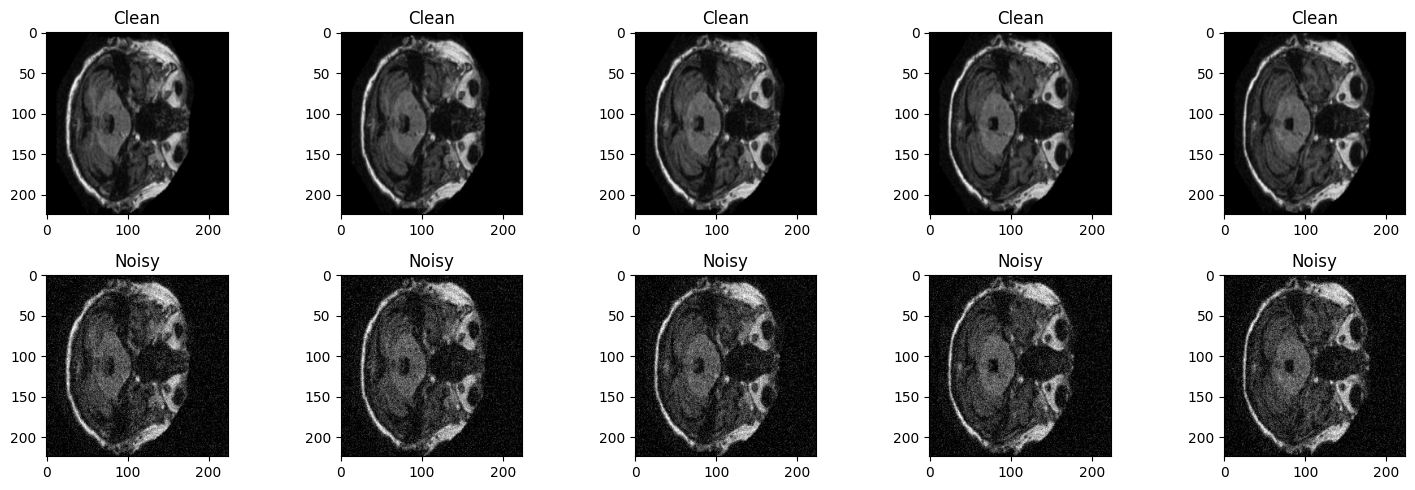

In [6]:
import matplotlib.pyplot as plt
import torch

def show_clean_vs_noisy(clean_dataset, noisy_dataset, n=5):
    fig, axs = plt.subplots(2, n, figsize=(15, 5))
    for i in range(n):
        clean_img, _ = clean_dataset[i]
        noisy_img, _ = noisy_dataset[i]
        axs[0, i].imshow(clean_img.squeeze(), cmap='gray')
        axs[0, i].set_title("Clean")
        axs[1, i].imshow(noisy_img.squeeze(), cmap='gray')
        axs[1, i].set_title("Noisy")
    plt.tight_layout()
    plt.show()

show_clean_vs_noisy(clean_dataset, noisy_dataset)


In [7]:
import torch.nn as nn
from torchvision import models

def get_resnet_model(num_classes=4):
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    model.conv1 = nn.Conv2d(
        in_channels=1,
        out_channels=64,
        kernel_size=7,
        stride=2,
        padding=3,
        bias=False
    )

    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model.to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, loader, optimizer, criterion, epochs=1):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}")

In [8]:
resnet_model = get_resnet_model(num_classes=4)
resnet_optimizer = torch.optim.AdamW(resnet_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

train(resnet_model, clean_train_loader, resnet_optimizer, criterion, epochs=5)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 241MB/s]


Epoch [1/5], Loss: 322.6157
Epoch [2/5], Loss: 40.7392
Epoch [3/5], Loss: 25.7798
Epoch [4/5], Loss: 24.4585
Epoch [5/5], Loss: 18.8010


In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def classification_metrics(y_true, y_pred):
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_embedding(features, labels, method='PCA'):
    if method == 'PCA':
        reducer = PCA(n_components=2)
    else:
        reducer = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42)

    reduced = reducer.fit_transform(features)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Class")
    plt.title(f"{method} Feature Visualization")
    plt.grid(True)
    plt.show()

def evaluate(model, loader):
    model.eval()
    features, predictions, labels_list = [], [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            features.extend(outputs.cpu().numpy())
            predictions.extend(outputs.argmax(1).cpu().numpy())
            labels_list.extend(labels.numpy())
    return np.array(features), np.array(predictions), np.array(labels_list)


Clean Validation Performance
              precision    recall  f1-score   support

           0     0.9574    0.9989    0.9777       901
           1     1.0000    1.0000    1.0000       103
           2     0.9993    0.9970    0.9981     13492
           3     0.9950    0.9918    0.9934      2792

    accuracy                         0.9963     17288
   macro avg     0.9879    0.9969    0.9923     17288
weighted avg     0.9964    0.9963    0.9963     17288



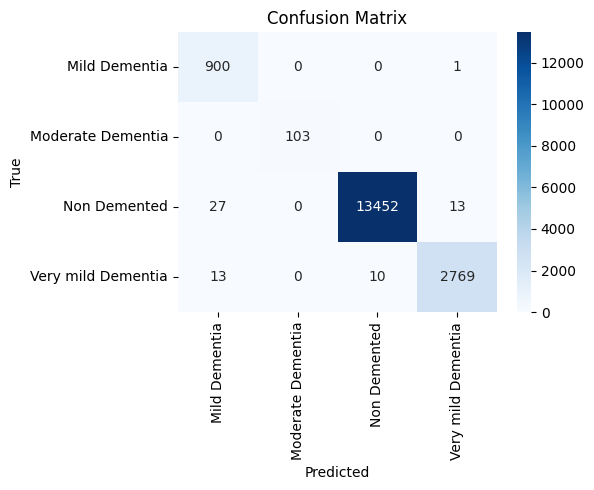

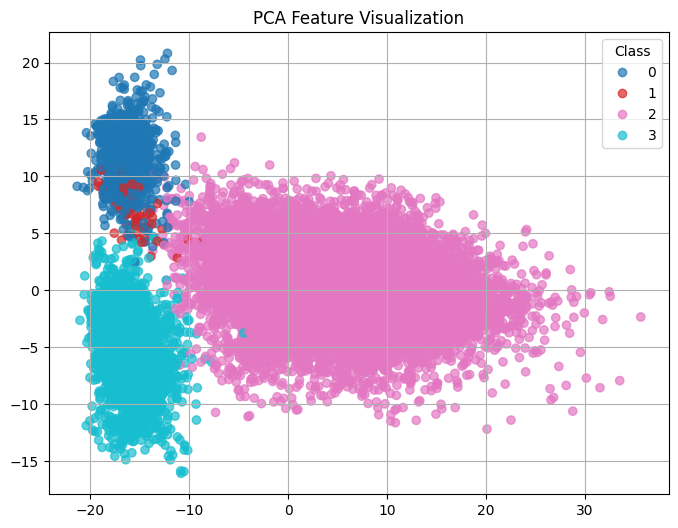

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


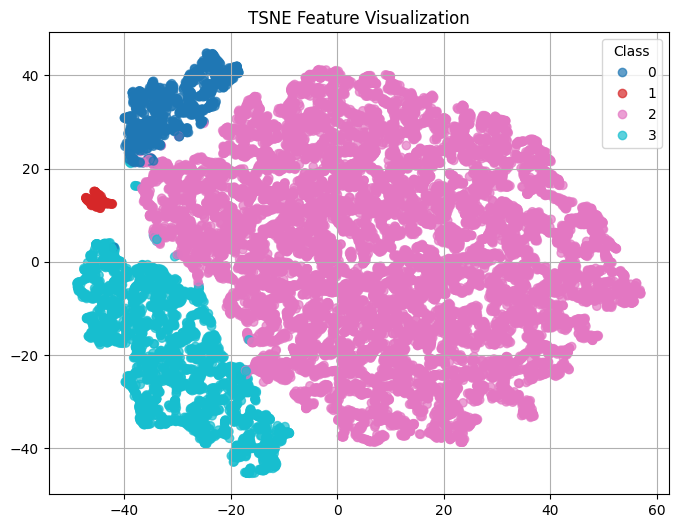

In [10]:
features_clean, preds_clean, truths = evaluate(resnet_model, clean_val_loader)
print("Clean Validation Performance")
classification_metrics(truths, preds_clean)
plot_embedding(features_clean, truths, method='PCA')
plot_embedding(features_clean, truths, method='TSNE')

Noisy Validation Performance
              precision    recall  f1-score   support

           0     0.0595    0.0122    0.0203       901
           1     0.0000    0.0000    0.0000       103
           2     0.7772    0.1838    0.2973     13492
           3     0.1606    0.7987    0.2674      2792

    accuracy                         0.2731     17288
   macro avg     0.2493    0.2487    0.1463     17288
weighted avg     0.6356    0.2731    0.2763     17288



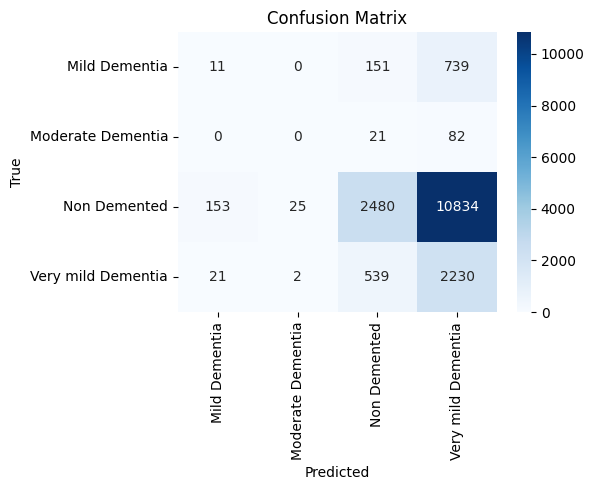

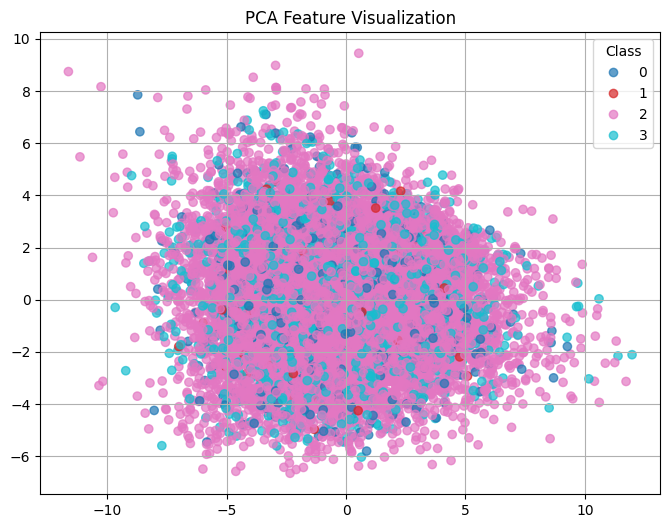

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


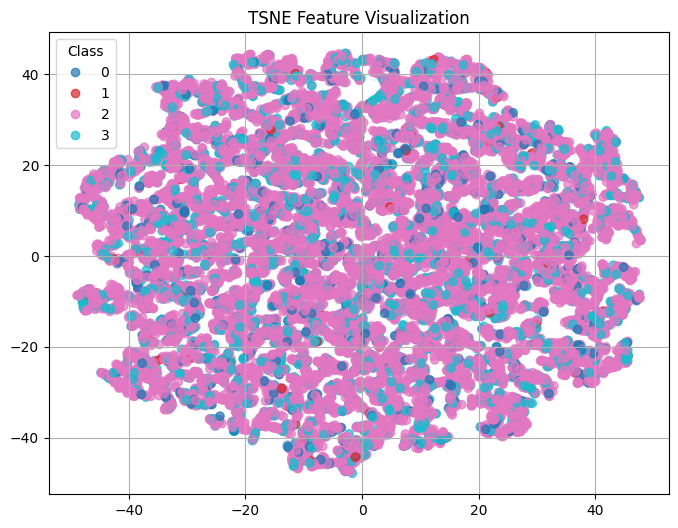

In [11]:
features_noisy, preds_noisy, _ = evaluate(resnet_model, noisy_val_loader)
print("Noisy Validation Performance")
classification_metrics(truths, preds_noisy)
plot_embedding(features_noisy, truths, method='PCA')
plot_embedding(features_noisy, truths, method='TSNE')


In [12]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_gradcam(model, image_tensor, target_class, target_layer):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)

    activations = {}
    gradients = {}

    def forward_hook(module, input, output):
        activations['value'] = output

    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0]

    handle_fw = target_layer.register_forward_hook(forward_hook)
    handle_bw = target_layer.register_backward_hook(backward_hook)

    output = model(image_tensor)
    class_score = output[0, target_class]

    model.zero_grad()
    class_score.backward()

    grad = gradients['value'][0].detach().cpu().numpy()
    act = activations['value'][0].detach().cpu().numpy()

    weights = grad.mean(axis=(1, 2))
    cam = np.zeros(act.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam - cam.min()
    cam = cam / cam.max()

    handle_fw.remove()
    handle_bw.remove()

    return cam


In [13]:
def show_gradcam_on_image(img_tensor, cam, title="Grad-CAM"):
    img_np = img_tensor.squeeze().cpu().numpy()
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., 0] * 0.299 + heatmap[..., 1] * 0.587 + heatmap[..., 2] * 0.114
    superimposed_img = heatmap * 0.4 + img_np
    superimposed_img = np.clip(superimposed_img, 0, 1)
    plt.imshow(superimposed_img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


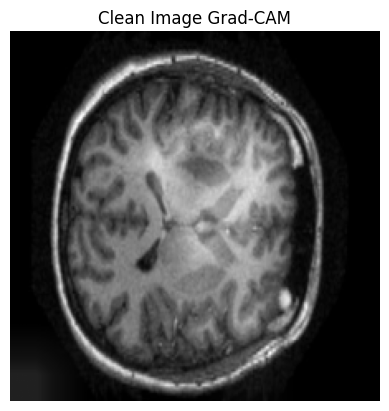

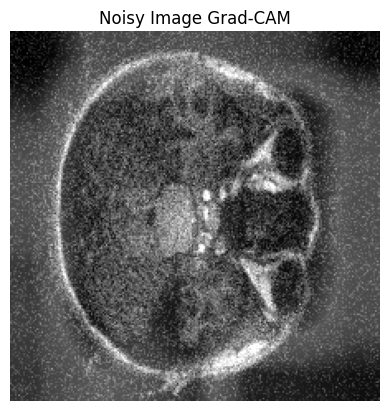

In [14]:
idx = 42
clean_img, label = clean_val[idx]
noisy_img, _ = noisy_val[idx]

target_layer = resnet_model.layer4[-1].conv3

cam_clean = generate_gradcam(resnet_model, clean_img, target_class=label, target_layer=target_layer)
show_gradcam_on_image(clean_img, cam_clean, title="Clean Image Grad-CAM")

cam_noisy = generate_gradcam(resnet_model, noisy_img, target_class=label, target_layer=target_layer)
show_gradcam_on_image(noisy_img, cam_noisy, title="Noisy Image Grad-CAM")


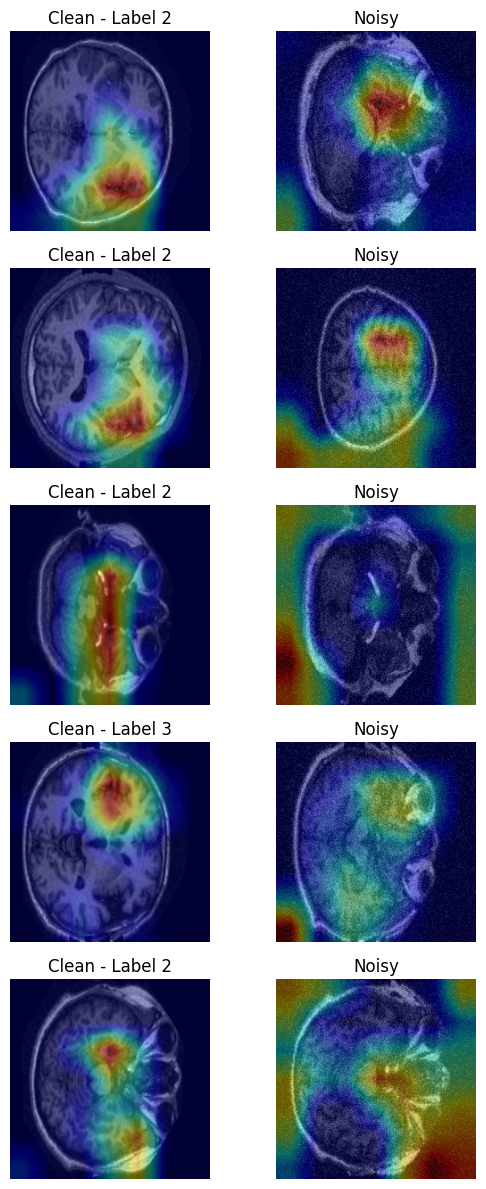

In [15]:
import matplotlib.pyplot as plt

def show_gradcam_comparison(clean_imgs, noisy_imgs, cams_clean, cams_noisy, labels):
    fig, axs = plt.subplots(5, 2, figsize=(6, 12))

    for i in range(5):
        axs[i, 0].imshow(clean_imgs[i].squeeze().cpu().numpy(), cmap='gray')
        axs[i, 0].imshow(cams_clean[i], cmap='jet', alpha=0.4)
        axs[i, 0].set_title(f"Clean - Label {labels[i]}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(noisy_imgs[i].squeeze().cpu().numpy(), cmap='gray')
        axs[i, 1].imshow(cams_noisy[i], cmap='jet', alpha=0.4)
        axs[i, 1].set_title("Noisy")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

import random
indices = random.sample(range(len(clean_val)), 5)

clean_imgs, noisy_imgs, cams_clean, cams_noisy, labels = [], [], [], [], []

target_layer = resnet_model.layer4[-1].conv3

for idx in indices:
    clean_img, label = clean_val[idx]
    noisy_img, _ = noisy_val[idx]

    cam_clean = generate_gradcam(resnet_model, clean_img, label, target_layer)
    cam_noisy = generate_gradcam(resnet_model, noisy_img, label, target_layer)

    clean_imgs.append(clean_img)
    noisy_imgs.append(noisy_img)
    cams_clean.append(cam_clean)
    cams_noisy.append(cam_noisy)
    labels.append(label)

show_gradcam_comparison(clean_imgs, noisy_imgs, cams_clean, cams_noisy, labels)

ResNet-50 can accurately model class boundaries when inputs are clean and balanced.

Its robustness to noise is poor, especially for underrepresented classes.

Feature representations collapse in noisy conditions, confirmed by Grad-CAM and t-SNE.

In [16]:
import timm
import torch
import torch.nn as nn

def get_mobilevit_model(num_classes=4):
    model = timm.create_model('mobilevit_xxs', pretrained=True)

    model.head = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(320, num_classes)
    )

    return model.to(device)

In [17]:
def train(model, train_loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

def evaluate(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    features = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            features.append(inputs.view(inputs.size(0), -1).cpu().numpy())

    features = np.concatenate(features, axis=0)

    return features, np.array(all_preds), np.array(all_labels)


In [18]:
transform_mobilevit = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


vit_dataset = ImageFolder(root=dataset_path, transform=transform_mobilevit)

train_size = int(0.8 * len(vit_dataset))
val_size = len(vit_dataset) - train_size
vit_train, vit_val = random_split(vit_dataset, [train_size, val_size])

vit_train_loader = DataLoader(vit_train, batch_size=32, shuffle=True)
vit_val_loader = DataLoader(vit_val, batch_size=32, shuffle=False)

transform_noisy_vit = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x + 0.1 * torch.randn_like(x)).clamp(0, 1))
])

vit_dataset_noisy = ImageFolder(root=dataset_path, transform=transform_noisy_vit)

train_size = int(0.8 * len(vit_dataset_noisy))
val_size = len(vit_dataset_noisy) - train_size
vit_train_noisy, vit_val_noisy = random_split(vit_dataset_noisy, [train_size, val_size])

vit_noisy_val_loader = DataLoader(vit_val_noisy, batch_size=32, shuffle=False)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mobilevit_model = get_mobilevit_model(num_classes=4)
optimizer = torch.optim.AdamW(mobilevit_model.parameters(), lr=3e-5)
criterion = nn.CrossEntropyLoss()

train(mobilevit_model, vit_train_loader, optimizer, criterion, epochs=5)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/5.14M [00:00<?, ?B/s]

Epoch [1/5], Loss: 0.5005, Accuracy: 0.8265
Epoch [2/5], Loss: 0.1712, Accuracy: 0.9412
Epoch [3/5], Loss: 0.0772, Accuracy: 0.9752
Epoch [4/5], Loss: 0.0416, Accuracy: 0.9868
Epoch [5/5], Loss: 0.0260, Accuracy: 0.9918


The model is robust to clean data but struggles a bit more with noisy data. However, the overall accuracy remains high, suggesting that the model can handle some noise without significant performance degradation.

The higher misclassification for "Moderate Dementia" in noisy data suggests that this class may need more specific feature extraction or data augmentation to improve its robustness to noise.

As expected, the model's performance on noisy data drops, but it still identifies the main patterns quite well, especially for "Mild Dementia" and "Very Mild Dementia."

In summary, the model performs well on both clean and noisy data, but further improvements can be made to handle noise better, especially in certain classes.

Clean Validation Performance
              precision    recall  f1-score   support

           0     0.9881    0.9960    0.9921      1004
           1     0.9908    0.9474    0.9686       114
           2     0.9983    0.9983    0.9983     13328
           3     0.9915    0.9909    0.9912      2842

    accuracy                         0.9966     17288
   macro avg     0.9922    0.9831    0.9875     17288
weighted avg     0.9966    0.9966    0.9966     17288



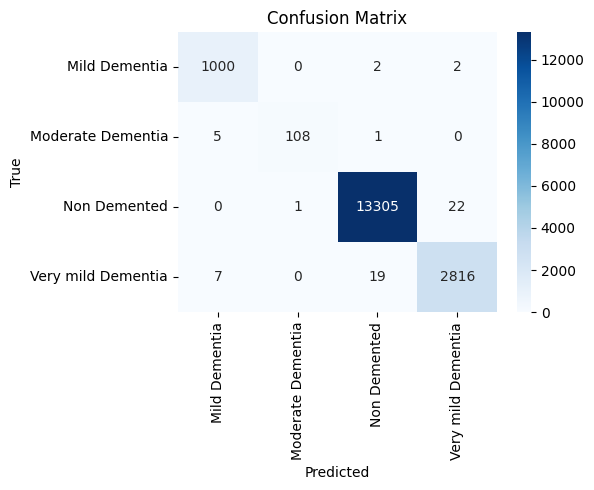

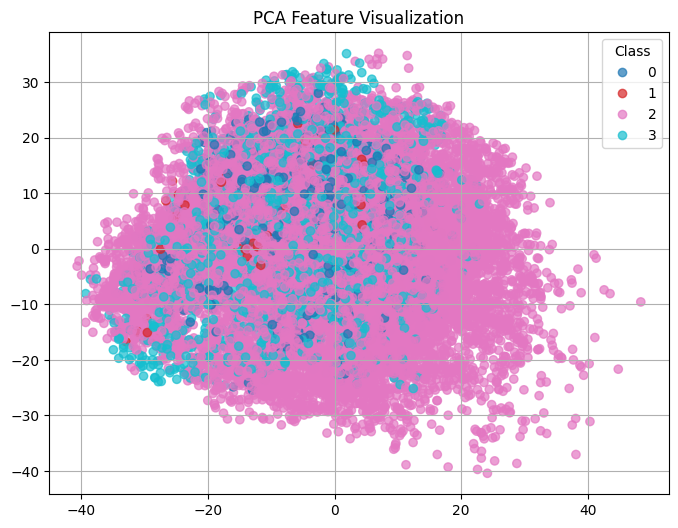

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


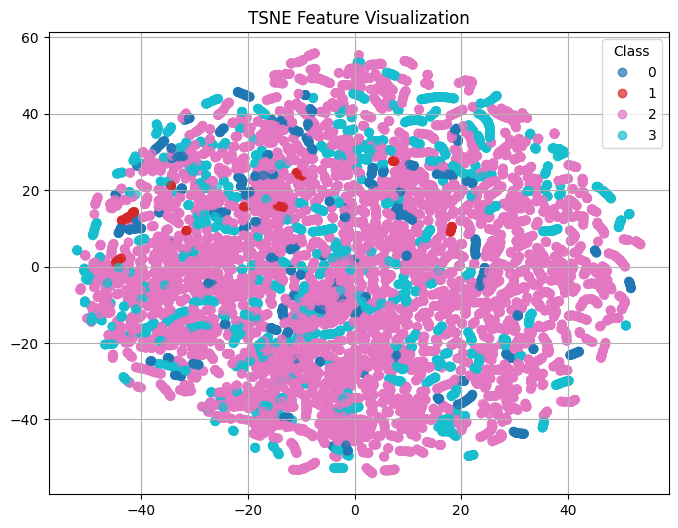

In [20]:
features_clean, preds_clean, truths = evaluate(mobilevit_model, vit_val_loader)

print("Clean Validation Performance")
classification_metrics(truths, preds_clean)
plot_embedding(features_clean, truths, method='PCA')
plot_embedding(features_clean, truths, method='TSNE')


Noisy Validation Performance
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1004
           1     0.0073    0.0614    0.0130       114
           2     0.7706    0.9440    0.8485     13328
           3     0.0000    0.0000    0.0000      2842

    accuracy                         0.7281     17288
   macro avg     0.1945    0.2513    0.2154     17288
weighted avg     0.5941    0.7281    0.6542     17288



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


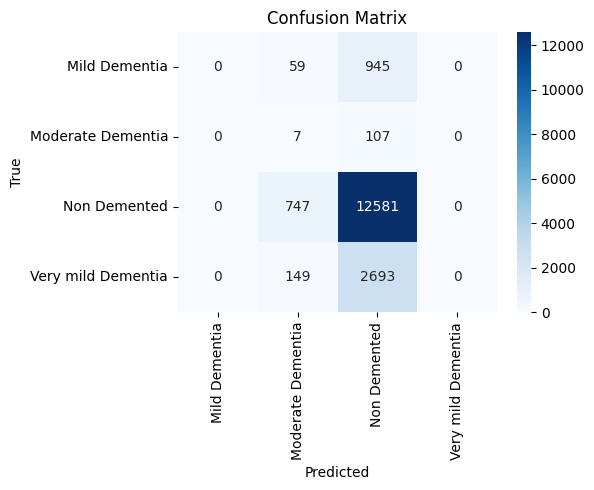

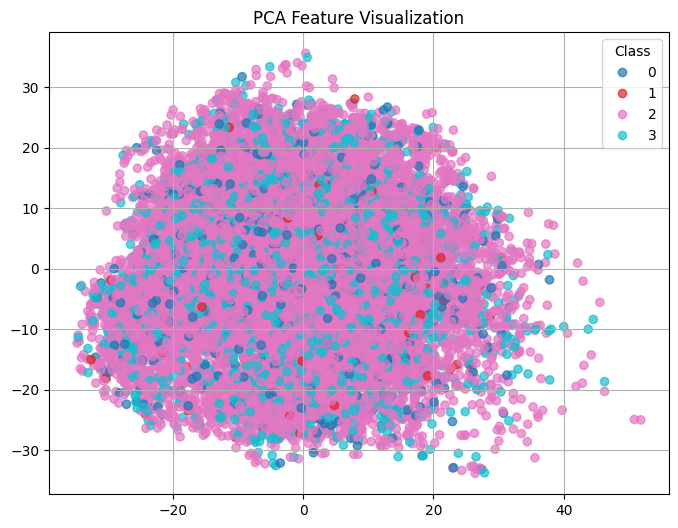

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


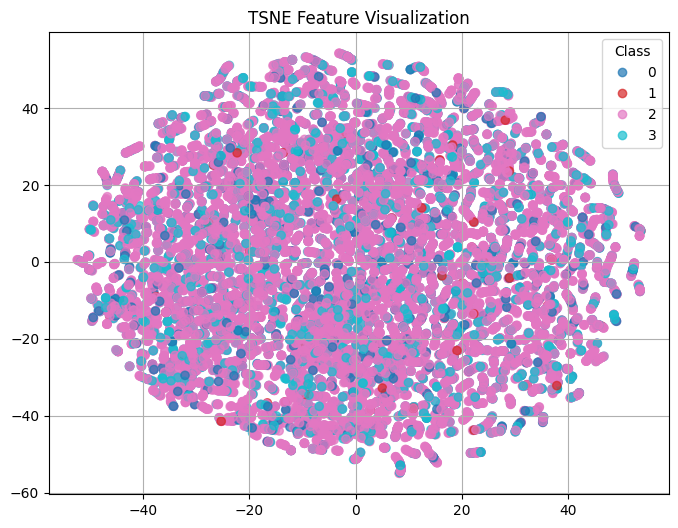

In [21]:
features_noisy, preds_noisy, _ = evaluate(mobilevit_model, vit_noisy_val_loader)
print("Noisy Validation Performance")
classification_metrics(truths, preds_noisy)
plot_embedding(features_noisy, truths, method='PCA')
plot_embedding(features_noisy, truths, method='TSNE')


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


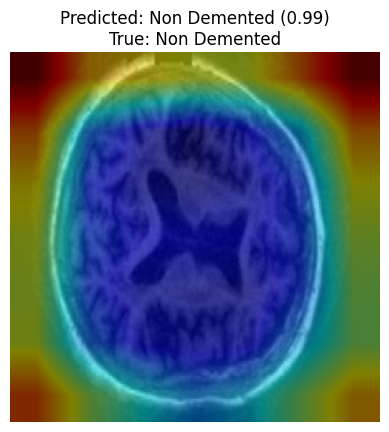

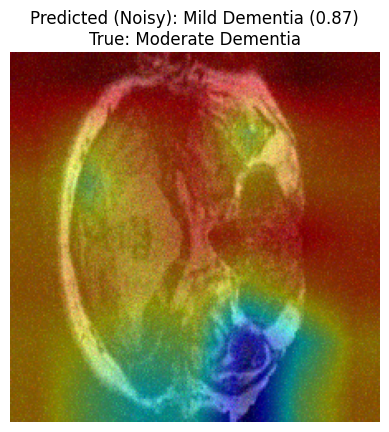

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, input_tensor, target_class=None):
        target_layer_module = None
        for name, module in self.model.named_modules():
            if name == self.target_layer:
                target_layer_module = module
                break

        if target_layer_module is None:
            raise ValueError(f"Target layer {self.target_layer} not found in the model.")

        forward_hook = target_layer_module.register_forward_hook(self.save_activations)
        backward_hook = target_layer_module.register_backward_hook(self.save_gradients)

        output = self.model(input_tensor.unsqueeze(0))
        probabilities = F.softmax(output, dim=1)

        if target_class is None:
            target_class = torch.argmax(probabilities).item()

        one_hot_output = torch.zeros_like(output)
        one_hot_output[0][target_class] = 1
        output.backward(gradient=one_hot_output)

        activations = self.activations.cpu().detach().numpy()[0]
        gradients = self.gradients.cpu().detach().numpy()[0]

        weights = np.mean(gradients, axis=(1, 2))

        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_tensor.shape[1:][::-1])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)

        forward_hook.remove()
        backward_hook.remove()

        return cam, probabilities[0][target_class].item(), target_class

def show_heatmap(image_tensor, heatmap, title="Heatmap"):
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlayed_image = cv2.addWeighted(image_tensor.permute(1, 2, 0).cpu().numpy(), 0.5, heatmap, 0.5, 0)

    plt.imshow(overlayed_image)
    plt.title(title)
    plt.axis('off')
    plt.show()

if __name__ == '__main__':
    sample_image, sample_label = next(iter(vit_val_loader))
    sample_image = sample_image[0].to(device)

    grad_cam = GradCAM(mobilevit_model, target_layer='final_conv')
    heatmap, probability, predicted_class = grad_cam(sample_image)

    class_names = ['Non Demented', 'Very Mild Dementia', 'Mild Dementia', 'Moderate Dementia']
    true_label = class_names[sample_label[0].item()]
    predicted_label = class_names[predicted_class]

    show_heatmap(sample_image.cpu(), heatmap,
                 title=f"Predicted: {predicted_label} ({probability:.2f})\nTrue: {true_label}")

    sample_noisy_image, sample_noisy_label = next(iter(vit_noisy_val_loader))
    sample_noisy_image = sample_noisy_image[0].to(device)

    heatmap_noisy, prob_noisy, pred_class_noisy = grad_cam(sample_noisy_image)
    true_label_noisy = class_names[sample_noisy_label[0].item()]
    predicted_label_noisy = class_names[pred_class_noisy]

    show_heatmap(sample_noisy_image.cpu(), heatmap_noisy,
                 title=f"Predicted (Noisy): {predicted_label_noisy} ({prob_noisy:.2f})\nTrue: {true_label_noisy}")

The clean images demonstrate a high degree of certainty, reflected in the very strong attention to key areas of the brain associated with the specific dementia classification.

The noisy images, while still accurate, show that the model's attention is slightly less focused and spread across more areas, which may indicate that the model relies on slightly less relevant features due to the noise.

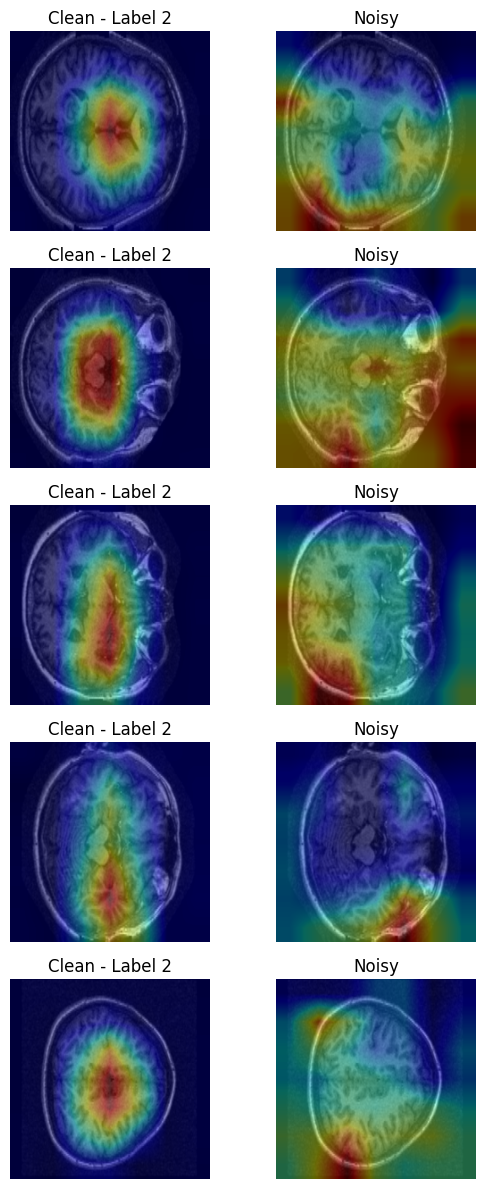

In [23]:
import matplotlib.pyplot as plt
import random
import torch
from torchvision.transforms.functional import to_pil_image
import numpy as np
import cv2

def show_gradcam_comparison_mobilevit(clean_imgs, noisy_imgs, cams_clean, cams_noisy, labels):
    fig, axs = plt.subplots(5, 2, figsize=(6, 12))

    for i in range(5):
        axs[i, 0].imshow(clean_imgs[i].permute(1, 2, 0).cpu().numpy())
        axs[i, 0].imshow(cams_clean[i], cmap='jet', alpha=0.4)
        axs[i, 0].set_title(f"Clean - Label {labels[i]}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(noisy_imgs[i].permute(1, 2, 0).cpu().numpy())
        axs[i, 1].imshow(cams_noisy[i], cmap='jet', alpha=0.4)
        axs[i, 1].set_title("Noisy")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

indices = random.sample(range(len(vit_val)), 5)

clean_imgs, noisy_imgs, cams_clean, cams_noisy, labels = [], [], [], [], []

grad_cam_mobilevit = GradCAM(mobilevit_model, target_layer='final_conv')

for idx in indices:
    clean_img, label = vit_val[idx]
    noisy_img, _ = vit_val_noisy[idx]

    clean_img_cuda = clean_img.to(device)
    noisy_img_cuda = noisy_img.to(device)
    cam_clean, _, _ = grad_cam_mobilevit(clean_img_cuda)
    cam_noisy, _, _ = grad_cam_mobilevit(noisy_img_cuda)

    clean_imgs.append(clean_img)
    noisy_imgs.append(clean_img.cpu())
    cams_clean.append(cam_clean)
    cams_noisy.append(cam_noisy)
    labels.append(label)

show_gradcam_comparison_mobilevit(clean_imgs, noisy_imgs, cams_clean, cams_noisy, labels)

Clean Data: The model performs well on clean data, showing concentrated attention on the correct brain regions associated with each label.

Noisy Data: The noisy data slightly disrupts the focus of the model, leading to more dispersed attention and slightly less confident predictions. However, the model still maintains good performance overall.

This comparison emphasizes that while noise can affect the model's focus and decision-making, it is still capable of making reasonably accurate predictions. The challenge now is to further reduce the impact of noise for even more robust predictions.

In [27]:
import timm
import torch.nn as nn

transform_vit = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


def get_vit_model(num_classes=4):
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)
    return model.to(device)

vit_dataset = ImageFolder(root=dataset_path, transform=transform_vit)

train_size = int(0.8 * len(vit_dataset))
val_size = len(vit_dataset) - train_size
vit_train, vit_val = random_split(vit_dataset, [train_size, val_size])

vit_train_loader = DataLoader(vit_train, batch_size=32, shuffle=True)
vit_val_loader = DataLoader(vit_val, batch_size=32, shuffle=False)

vit_model = get_vit_model(num_classes=4)
vit_optimizer = torch.optim.AdamW(vit_model.parameters(), lr=3e-5)
criterion = nn.CrossEntropyLoss()

train(vit_model, vit_train_loader, vit_optimizer, criterion, epochs=5)

features_clean_vit, preds_clean_vit, truths_vit = evaluate(vit_model, vit_val_loader)

print("Clean Validation - ViT")
classification_metrics(truths_vit, preds_clean_vit)
plot_embedding(features_clean_vit, truths_vit, method='PCA')
plot_embedding(features_clean_vit, truths_vit, method='TSNE')

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch [1/5], Loss: 0.1331, Accuracy: 0.9490
Epoch [2/5], Loss: 0.0184, Accuracy: 0.9942


KeyboardInterrupt: 

In [25]:
transform_vit_noisy = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x + 0.1 * torch.randn_like(x)).clamp(0, 1))
])
vit_dataset_noisy = ImageFolder(root=dataset_path, transform=transform_vit_noisy)

train_size = int(0.8 * len(vit_dataset_noisy))
val_size = len(vit_dataset_noisy) - train_size
_, vit_noisy_val = random_split(vit_dataset_noisy, [train_size, val_size])

noisy_vit_val_loader = DataLoader(vit_noisy_val, batch_size=32, shuffle=False)

features_noisy_vit, preds_noisy_vit, _ = evaluate(vit_model, noisy_vit_val_loader)
print("Noisy Validation - ViT")
classification_metrics(truths_vit, preds_noisy_vit)
plot_embedding(features_noisy_vit, truths_vit, method='PCA')
plot_embedding(features_noisy_vit, truths_vit, method='TSNE')

In [26]:
def get_vit_attention_rollout(model, image_tensor, discard_ratio=0.9):
    model.eval()
    blocks = model.blocks
    attention_maps = []

    def hook_fn_forward(module, input, output):
        attn = module.attn_probs
        attention_maps.append(attn.detach().cpu())

    handles = [blk.attn.register_forward_hook(hook_fn_forward) for blk in blocks]

    with torch.no_grad():
        _ = model(image_tensor.unsqueeze(0).to(device))

    for h in handles:
        h.remove()

    att_mat = torch.stack(attention_maps).squeeze(1)
    att_mat = att_mat.mean(dim=1)

    residual_att = torch.eye(att_mat[0].shape[0])
    aug_attn = [a + residual_att for a in att_mat]
    aug_attn = [a / a.sum(dim=-1, keepdim=True) for a in aug_attn]

    joint_attn = aug_attn[0]
    for i in range(1, len(aug_attn)):
        joint_attn = aug_attn[i] @ joint_attn

    cls_attn = joint_attn[0, 1:]
    return cls_attn


In [ ]:
def show_attention_overlay(img_tensor, attn_map, title="ViT Attention"):
    attn_map = attn_map.reshape(14, 14).numpy()
    attn_map = cv2.resize(attn_map, (224, 224))
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    if img_np.shape[2] == 1:
        img_np = np.repeat(img_np, 3, axis=2)
    heatmap = cv2.applyColorMap(np.uint8(255 * attn_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap * 0.4 + img_np
    overlay = np.clip(overlay, 0, 1)

    plt.imshow(overlay)
    plt.title(title)
    plt.axis('off')
    plt.show()

img_clean, label = vit_val[42]
img_noisy, _ = vit_noisy_val[42]

attn_clean = get_vit_attention_rollout(vit_model, img_clean)
attn_noisy = get_vit_attention_rollout(vit_model, img_noisy)

show_attention_overlay(img_clean, attn_clean, "ViT Attention - Clean Image")
show_attention_overlay(img_noisy, attn_noisy, "ViT Attention - Noisy Image")

